# Haqiqi 2021 2a, using pyWBM inputs

## Packages

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS

## Inputs

In [7]:
csv_output_file_haqiqi2021_2a = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"

In [8]:
fips_level_inputs_pd = pd.read_csv(csv_output_file_haqiqi2021_2a) 
fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
fips_level_inputs_pd['year'] = fips_level_inputs_pd['year']**2
usda_pd = pd.read_csv(usda_filepath)

In [9]:
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]

# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')

# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]

usda_pd['log_yield'] = np.log(usda_pd['yield'])

fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)

# merge usda_pd & livneh_pd 
df = fips_level_inputs_pd.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
df['year2'] = df['year']**2

rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                   "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                   "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                   "46", "47", "48", "50", "51", "54", "55"]

df = df[df['state'].isin(rainfed_states)]

output_dir = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/0_uncertainity_figures/1_fips_pywbm_models"
os.makedirs(output_dir, exist_ok=True)
df_set_index = df.set_index(['fips', 'year'])

## Testing various models for different parameters

### Avila Model 1
### $logY_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM+ \beta_{3}SM^{2} + \beta_{2}year^2 + \beta_{\alpha}EDD_{binned} + c_{i} $
- no time effects
- does not regress on year, only year$^2$

In [14]:
# define the model with both entity and time fixed effects
model = PanelOLS.from_formula(
    ('log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + C(state):year2 '),
    data=df_set_index,
    )

# fit the model
results_h21 = model.fit()

GDD_param = results_h21.params.gdd.item()
EDD_SM_75_below_param = results_h21.params.edd_minus75.item()
EDD_SM_25_75_below_param = results_h21.params.edd_minus25_75.item()
EDD_SM_0_25_norm_param = results_h21.params.edd_minus25_plus25.item()
EDD_SM_25_75_above_param = results_h21.params.edd_plus25_75.item()
EDD_SM_75_above_param = results_h21.params.edd_plus75.item()
SM_mean_param = results_h21.params.SoilM_0_100cm.item()
SM_mean2_param = results_h21.params.SoilM_0_100cm_square.item()
year2 = results_h21.params.year2.item()

fips_number = '17113'

entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values

df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_h21 = (GDD_param * df_fip_01001['gdd'] + 
                     EDD_SM_75_below_param * df_fip_01001['edd_minus75'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['edd_minus25_75'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['edd_minus25_plus25'] +
                     EDD_SM_25_75_above_param * df_fip_01001['edd_plus25_75'] +
                     EDD_SM_75_above_param * df_fip_01001['edd_plus75'] +
                     SM_mean_param * df_fip_01001['SoilM_0_100cm'] +
                     SM_mean2_param * df_fip_01001['SoilM_0_100cm_square'] +
                     year2 * df_fip_01001['year2'] + 
                    entity_effect)

plt.plot(df_fip_01001['year'], df_fip_01001['log_yield'], label='observed log yields')
plt.plot(df_fip_01001['year'],  model_predication_h21, label='avila26 model 1')
plt.title(f'fips {fips_number} year2, no time-effects')
plt.ylabel('log yield, bu/acre', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.legend()

results_df = results_h21.estimated_effects['estimated_effects']
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"
counties = gpd.read_file(county_shp_path)
averaged_results = results_df.groupby('fips').mean()
merged = counties.merge(averaged_results, how='left', left_on='fips', right_on='fips')

fig, ax = plt.subplots(figsize=(8, 6))
merged.plot(column='estimated_effects', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Fixed Effects Avila Model 1, Year^2 pyWBM inputs', fontsize=13)


ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.

### Avila Model 2 
### $logY_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM+ \beta_{3}SM^{2} + \beta_{2}year^2 + \beta_{3}year + \beta_{\alpha}EDD_{binned} + c_{i} $
- no time effects

In [1]:
model = PanelOLS.from_formula(
    ('log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + C(state):year_input + C(state):year2 + EntityEffects'),
    data=df_set_index)

# fit the model
results_h21 = model.fit()

GDD_param = results_h21.params.gdd.item()
EDD_SM_75_below_param = results_h21.params.edd_minus75.item()
EDD_SM_25_75_below_param = results_h21.params.edd_minus25_75.item()
EDD_SM_0_25_norm_param = results_h21.params.edd_minus25_plus25.item()
EDD_SM_25_75_above_param = results_h21.params.edd_plus25_75.item()
EDD_SM_75_above_param = results_h21.params.edd_plus75.item()
SM_mean_param = results_h21.params.SoilM_0_100cm.item()
SM_mean2_param = results_h21.params.SoilM_0_100cm_square.item()
year_input = results_h21.params.year_input.item()
year2 = results_h21.params.year2.item()

fips_number = '17113'

entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values

df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_h21 = (GDD_param * df_fip_01001['gdd'] + 
                     EDD_SM_75_below_param * df_fip_01001['edd_minus75'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['edd_minus25_75'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['edd_minus25_plus25'] +
                     EDD_SM_25_75_above_param * df_fip_01001['edd_plus25_75'] +
                     EDD_SM_75_above_param * df_fip_01001['edd_plus75'] +
                     SM_mean_param * df_fip_01001['SoilM_0_100cm'] +
                     SM_mean2_param * df_fip_01001['SoilM_0_100cm_square'] +
                     year_input * df_fip_01001['year_input'] +
                     year2 * df_fip_01001['year2'] + 
                    entity_effect)

plt.plot(df_fip_01001['year'], df_fip_01001['log_yield'], label='observed log yields')
plt.plot(df_fip_01001['year'],  model_predication_h21, label='avila 26 model 2')
plt.title(f'fips {fips_number} year / year2, no time-effects, pyWBM inputs')
plt.ylabel('log yield, bu/acre', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.legend()

results_df = results_h21.estimated_effects['estimated_effects']
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"
counties = gpd.read_file(county_shp_path)
averaged_results = results_df.groupby('fips').mean()
merged = counties.merge(averaged_results, how='left', left_on='fips', right_on='fips')

fig, ax = plt.subplots(figsize=(8, 6))
merged.plot(column='estimated_effects', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Fixed Effects Avila Model 2, Year / Year^2 pyWBM inputs', fontsize=13)


NameError: name 'PanelOLS' is not defined

### Avila Model 3 (Haqiqi 2021 model 2a)
### $logY_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM + \beta_{3}SM^{2} + \beta_{\alpha}EDD_{binned} + c_{i} $
- no time effects
- not regressing on year or year$^2$

Text(0.5, 1.0, 'Haqiqi et. al 2021 Model 2a pyWBM inputs')

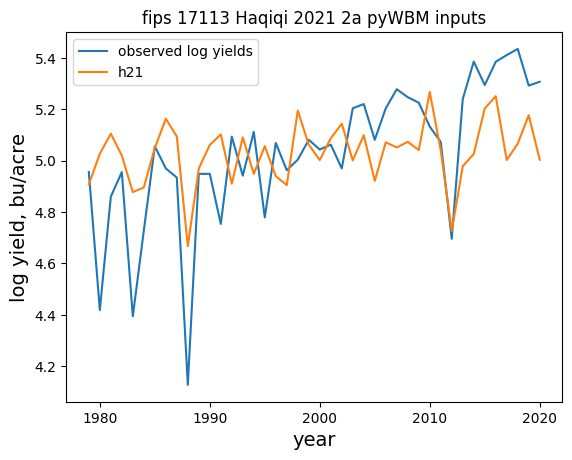

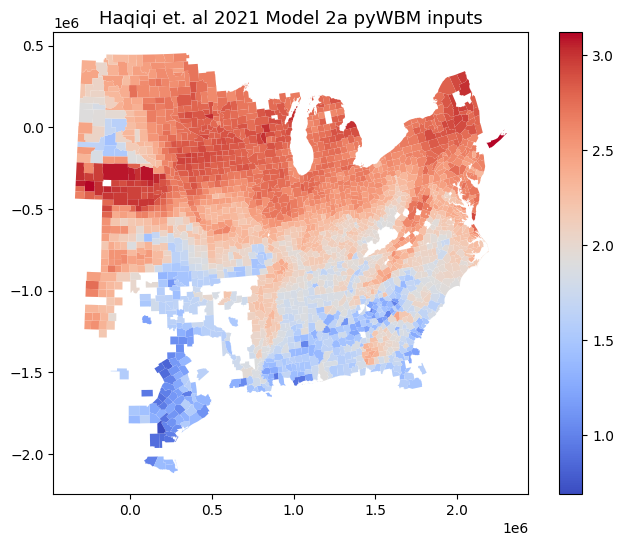

In [97]:
model = PanelOLS.from_formula(
    ('log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + EntityEffects'),
    data=df_set_index)

# fit the model
results_h21 = model.fit()

GDD_param = results_h21.params.gdd.item()
EDD_SM_75_below_param = results_h21.params.edd_minus75.item()
EDD_SM_25_75_below_param = results_h21.params.edd_minus25_75.item()
EDD_SM_0_25_norm_param = results_h21.params.edd_minus25_plus25.item()
EDD_SM_25_75_above_param = results_h21.params.edd_plus25_75.item()
EDD_SM_75_above_param = results_h21.params.edd_plus75.item()
SM_mean_param = results_h21.params.SoilM_0_100cm.item()
SM_mean2_param = results_h21.params.SoilM_0_100cm_square.item()


fips_number = '17113'

entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values

df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_h21 = (GDD_param * df_fip_01001['gdd'] + 
                     EDD_SM_75_below_param * df_fip_01001['edd_minus75'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['edd_minus25_75'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['edd_minus25_plus25'] +
                     EDD_SM_25_75_above_param * df_fip_01001['edd_plus25_75'] +
                     EDD_SM_75_above_param * df_fip_01001['edd_plus75'] +
                     SM_mean_param * df_fip_01001['SoilM_0_100cm'] +
                     SM_mean2_param * df_fip_01001['SoilM_0_100cm_square'] +
                    entity_effect)

plt.plot(df_fip_01001['year'], df_fip_01001['log_yield'], label='observed log yields')
plt.plot(df_fip_01001['year'],  model_predication_h21, label='h21')
plt.title(f'fips {fips_number} Haqiqi 2021 2a pyWBM inputs')
plt.ylabel('log yield, bu/acre', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.legend()

# fixed effects for this county
results_df = results_h21.estimated_effects['estimated_effects']
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"
counties = gpd.read_file(county_shp_path)
averaged_results = results_df.groupby('fips').mean()
merged = counties.merge(averaged_results, how='left', left_on='fips', right_on='fips')

fig, ax = plt.subplots(figsize=(8, 6))
merged.plot(column='estimated_effects', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Haqiqi et. al 2021 Model 2a pyWBM inputs', fontsize=13)
